##Árvore de regressão (ajuste)

In [39]:
import pandas as pd
import numpy as np

In [40]:
#Carregando o conjunto de dados
dados=pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')


In [41]:
dados.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [42]:
# Treinamento, validação e ajuste do modelo

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import cross_val_score

In [44]:
# Particionar o conjunto de dados (treinamento e validação)
x_train,x_test,y_train,y_test=train_test_split(dados.drop('medv',axis=1),dados['medv'],test_size=0.2,random_state=1)

In [45]:
#Ajuste de uma árvore alterando valores default
mod1=DecisionTreeRegressor(random_state=1,min_samples_leaf=5,min_samples_split=20,max_depth=4)
mod1.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=20,
                      random_state=1)

In [46]:
# Resumo (apenas uma variável foi utilizada na construção da árvore)
print(mod1)
print('Features importantes: ',mod1.feature_importances_)
print(dados.columns)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=5, min_samples_split=20,
                      random_state=1)
Features importantes:  [0.01847094 0.         0.00716072 0.         0.0744294  0.25808278
 0.01161429 0.00449766 0.         0.         0.01992293 0.
 0.60582129]
Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object')


In [47]:
# Criar o dataframe com as importancias: [:-1] significa "selecione todos os elementos da sequência exceto o ú8ltimo"
imp=pd.DataFrame({'Features':dados.columns[:-1],'Importancia':mod1.feature_importances_})
# Imprimir o DataFrame
print(imp)

   Features  Importancia
0      crim     0.018471
1        zn     0.000000
2     indus     0.007161
3      chas     0.000000
4       nox     0.074429
5        rm     0.258083
6       age     0.011614
7       dis     0.004498
8       rad     0.000000
9       tax     0.000000
10  ptratio     0.019923
11        b     0.000000
12    lstat     0.605821


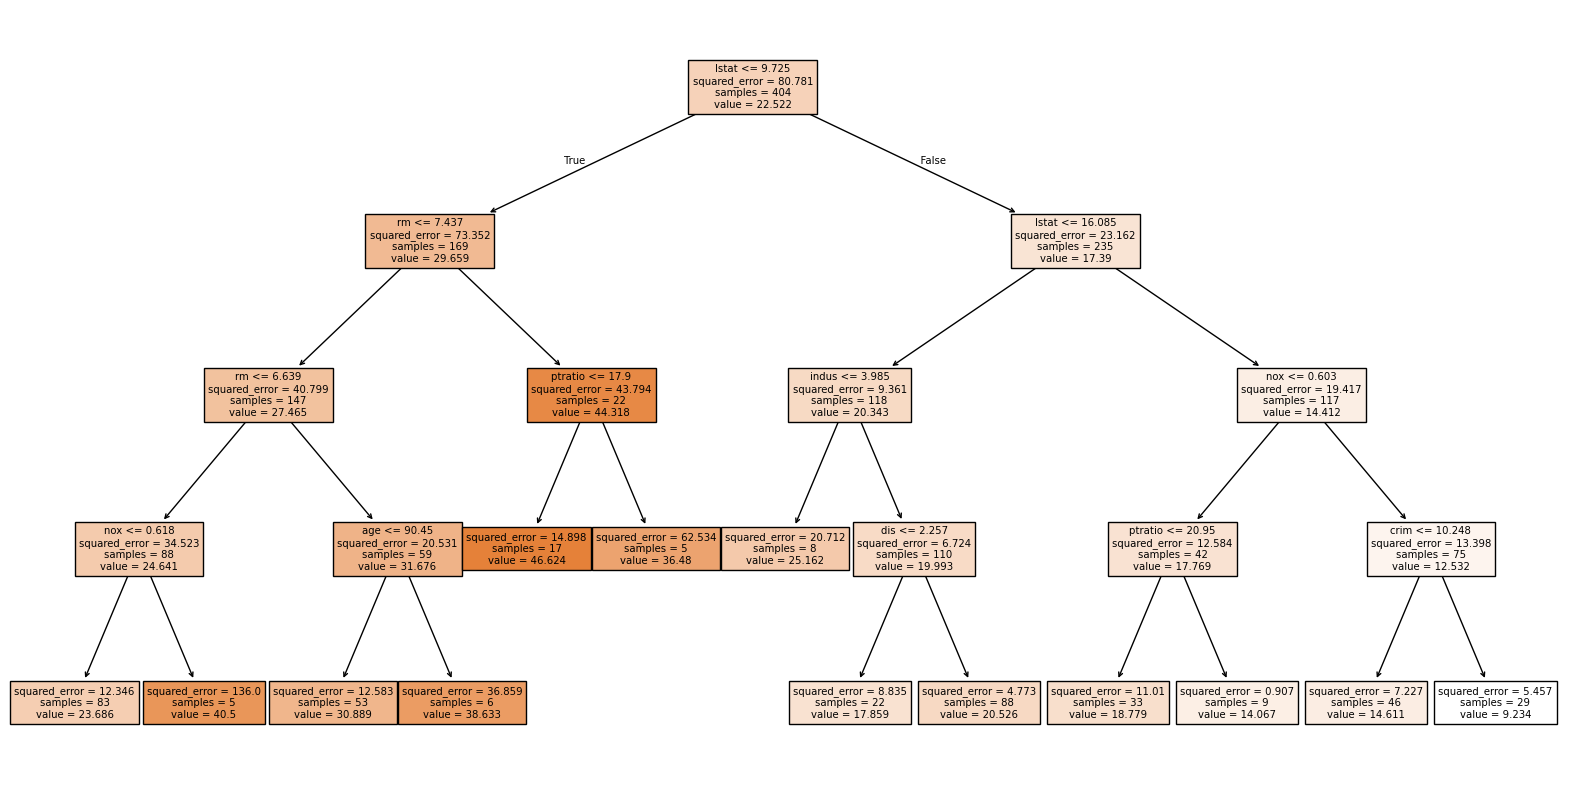

In [48]:
#Apresentação da árvore ajustada
plt.figure(figsize=(20,10))
plot_tree(mod1,filled=True,feature_names=x_train.columns)
plt.show()

## Árvore de regressão (poda)

In [49]:
## Poda#
#Poda da árvore (em python a poda é feita com ccp_alpha)
#À medida que o α aumenta, a penalidade por ter muitos nós aumenta, e a árvore fica menor.
#Árvores menores (maior alfa) são mais simples, mas geralmente têm uma impureza maior nos dados de treino.

path=mod1.cost_complexity_pruning_path(x_train,y_train)
cpp_alphas,impurities=path.ccp_alphas,path.impurities

In [50]:
# Encontrar o melhor ccp_alpha (equivalente ao best=6 no R)
best_ccp_alpha=cpp_alphas[np.argmin(impurities)] # np.argmin(impurities), procura em qual posição da lista impurities está o menor valor.
                                                # cpp_alphas[...]: Ela pega o valor de Alpha que está exatamente nessa mesma posição.
print(best_ccp_alpha)
mod_poda=DecisionTreeRegressor(random_state=1,ccp_alpha=best_ccp_alpha,min_samples_leaf=5,min_samples_split=20,max_depth=4)
mod_poda.fit(x_train,y_train)


0.0


DecisionTreeRegressor(ccp_alpha=np.float64(0.0), max_depth=4,
                      min_samples_leaf=5, min_samples_split=20, random_state=1)

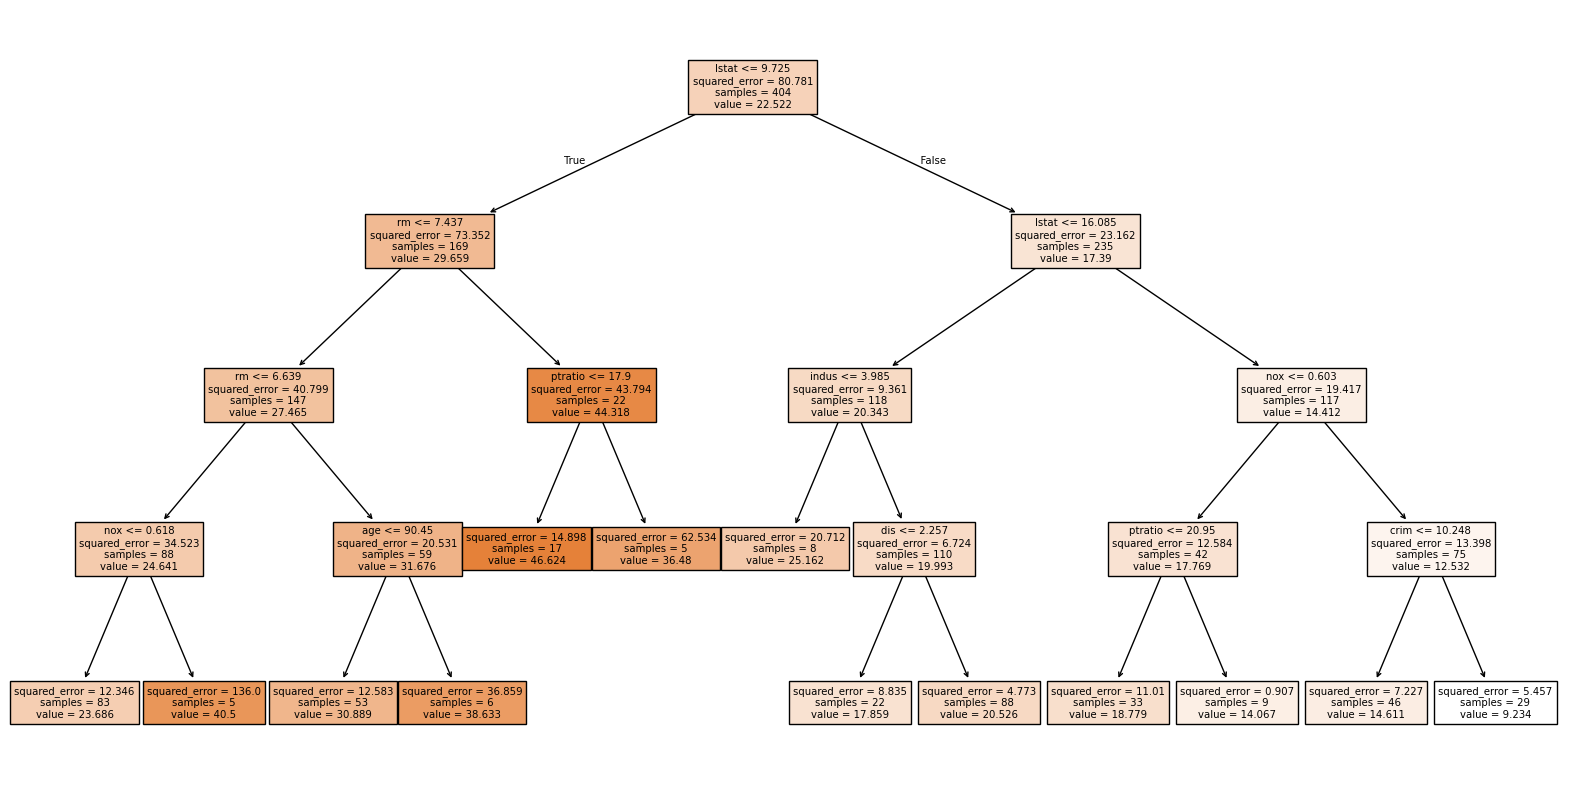

In [51]:
# Apresentação da árvore podada

plt.figure(figsize=(20,10))
plot_tree(mod_poda,filled=True,feature_names=x_train.columns)
plt.show()

In [52]:
# Predição (considerando o modelo sem poda)
yhat=mod1.predict(x_test)
boston_test=y_test

In [53]:
# Calcular o RMSE (Raiz do erro quadrático médio)
from sklearn.metrics import mean_squared_error
rmse=np.sqrt(mean_squared_error(boston_test,yhat))
print('RMSE: ',rmse)

RMSE:  4.455533348105255


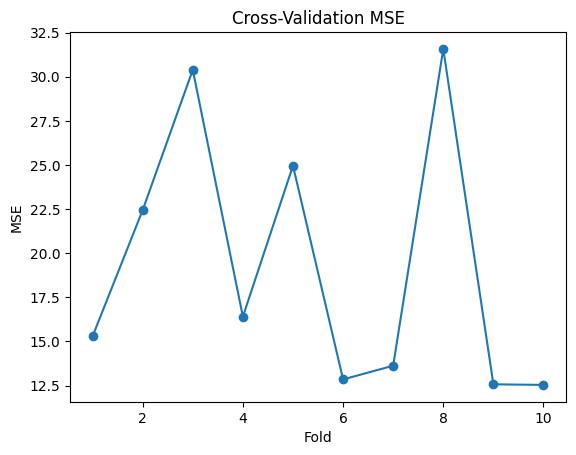

In [54]:
# Estudo de validação cruzada

cv_scores=cross_val_score(mod1,x_train,y_train,cv=10,scoring='neg_mean_squared_error')
cv_mse=-cv_scores #pega o valor positivo do mse
plt.plot(range(1,11),cv_mse,marker='o') #plota os valores do cross validation
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.title('Cross-Validation MSE')
plt.show()

In [55]:
print('Média do MSE: ',np.mean(cv_mse))
print('Desvio padrão do MSE: ',np.std(cv_mse))

Média do MSE:  19.26360606513066
Desvio padrão do MSE:  7.106379528196517


## Árvore de regressão (bagging e randomforest)

In [56]:
#Bagging
from sklearn.ensemble import RandomForestRegressor


In [57]:
# Bagging using RandomForetRegressor (mtry=13 means all features

mod_bag= RandomForestRegressor(n_estimators=100,max_features=13,random_state=1) # random_state
mod_bag.fit(x_train,y_train)

RandomForestRegressor(max_features=13, random_state=1)

In [58]:
# Model evaluation (Prediction)
yhat_bag=mod_bag.predict(x_test)
rmse_bag=np.sqrt(mean_squared_error(y_test,yhat_bag))
print(f'RMSE_bag: {rmse_bag}')

RMSE_bag: 2.9860173226189413


In [59]:
# Random Forest

mod_rf=RandomForestRegressor(n_estimators=100,max_features=4,random_state=1)
mod_rf.fit(x_train,y_train)



RandomForestRegressor(max_features=4, random_state=1)

In [60]:
# Predictions

yhat_rf=mod_rf.predict(x_test)

In [61]:
# RMSE

rmse_rf=np.sqrt(mean_squared_error(y_test,yhat_rf))
print(f'RMSE_rf: {rmse_rf}')


RMSE_rf: 3.1506317589321933


In [62]:
# Criar DataFrame com os valores do RMSE

In [63]:
rmse_data={'Modelo':['Regressão','Bagging','Random Forest'],'RMSE':[rmse,rmse_bag,rmse_rf]}
rmse_df=pd.DataFrame(rmse_data)
print(rmse_df)

          Modelo      RMSE
0      Regressão  4.455533
1        Bagging  2.986017
2  Random Forest  3.150632


In [64]:
# Feature importance Bagging
i_mod_bag=mod_bag.feature_importances_
print('Feature Importance: ')
for feature, importance in zip(x_train.columns,i_mod_bag):
  print(f'{feature}: {importance}')

Feature Importance: 
crim: 0.04026782402211185
zn: 0.0009627868598930243
indus: 0.00822586136370901
chas: 0.0008354702225570655
nox: 0.026228319000521874
rm: 0.278027492822481
age: 0.01939696739026326
dis: 0.0652787065477574
rad: 0.0037785432307005577
tax: 0.013418678105155617
ptratio: 0.019411772941481588
b: 0.01394795267108449
lstat: 0.5102196248222832


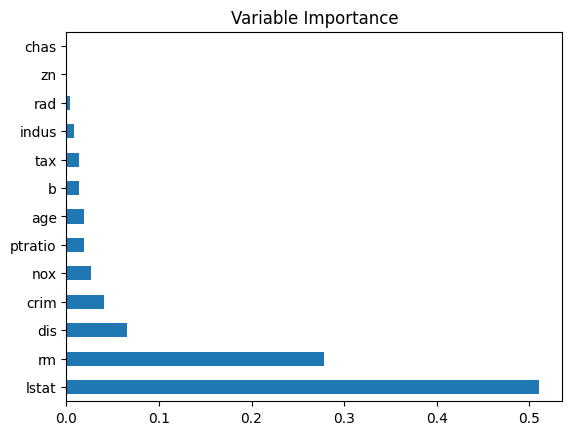

In [65]:
# Variable Importance Plot

feature_importances=pd.Series(i_mod_bag,index=x_train.columns)
feature_importances.nlargest(13).plot(kind='barh') # 13 features in Boston dataset
plt.title('Variable Importance')
plt.show()

## Àrvore de regressão (validação)

In [66]:
# Esquemas de validação
x=dados.drop('medv',axis=1)
y=dados['medv']

# Holdout

In [67]:
# Holdout

x_train_holdout,x_test_holdout,y_train_holdout,y_test_holdout=train_test_split(x,y,test_size=0.2,random_state=1)

In [68]:
mod_bag.fit(x_train_holdout,y_train_holdout)
yhat_holdout=mod_bag.predict(x_test_holdout)
rmse_bag_holdout=np.sqrt(mean_squared_error(y_test_holdout,yhat_holdout))
print(f'RMSE_bag_holdout: {rmse_bag_holdout}')

RMSE_bag_holdout: 2.9860173226189413


In [69]:
mod_rf.fit(x_train_holdout,y_train_holdout)
yhat_rf_holdout=mod_rf.predict(x_test_holdout)
rmse_rf_holdout=np.sqrt(mean_squared_error(y_test_holdout,yhat_rf_holdout))
print(f'RMSE_rf_holdout: {rmse_rf_holdout}')

RMSE_rf_holdout: 3.1506317589321933


# K-fold

In [70]:
# K-Fold Cross-Validation
from sklearn.model_selection import train_test_split,KFold,LeaveOneOut

In [71]:
kf=KFold(n_splits=5,shuffle=True,random_state=1)

In [72]:
rmse_bag_kfold=[] #Listas vazias para armazenar os valorees de rmse
rmse_rf_kfold=[]

In [73]:
for train_index,test_index in kf.split(x):
  x_train_kfold,x_test_kfold=x.iloc[train_index],x.iloc[test_index]
  y_train_kfold,y_test_kfold=y.iloc[train_index],y.iloc[test_index]

  mod_bag.fit(x_train_kfold,y_train_kfold)
  yhat_bag_kfold=mod_bag.predict(x_test_kfold)
  rmse_bag_kfold.append(np.sqrt(mean_squared_error(y_test_kfold,yhat_bag_kfold)))

  mod_rf.fit(x_train_kfold,y_train_kfold)
  yhat_rf_kfold=mod_rf.predict(x_test_kfold)
  rmse_rf_kfold.append(np.sqrt(mean_squared_error(y_test_kfold,yhat_rf_kfold)))

rmse_bag_kfold=np.mean(rmse_bag_kfold)
rmse_rf_kfold=np.mean(rmse_rf_kfold)



In [74]:
rmse_bag_kfold

np.float64(3.420539778732814)

In [75]:
rmse_rf_kfold

np.float64(3.29019368525937)

## Jacknife (Leave-One-Out Cross-Validation)

In [76]:
loo=LeaveOneOut() # Criamos um objeto LeaveOneOut

In [77]:
rmse_bag_jackknife=[] #listas vazias para armazenar os valores de rmse
rmse_rf_jackknife=[]

In [78]:
for train_index,test_index in loo.split(x):
  x_train_jackknife,x_test_jackknife=x.iloc[train_index],x.iloc[test_index]
  y_train_jackknife,y_test_jackknife=y.iloc[train_index],y.iloc[test_index]

  mod_bag.fit(x_train_jackknife,y_train_jackknife)
  yhat_bag_jackknife=mod_bag.predict(x_test_jackknife)
  rmse_bag_jackknife.append(np.sqrt(mean_squared_error(y_test_jackknife,yhat_bag_jackknife)))

  mod_rf.fit(x_train_jackknife,y_train_jackknife)
  yhat_rf_jackknife=mod_rf.predict(x_test_jackknife)
  rmse_rf_jackknife.append(np.sqrt(mean_squared_error(y_test_jackknife,yhat_rf_jackknife)))

rmse_bag_jackknife=np.mean(rmse_bag_jackknife)
rmse_rf_jackknife=np.mean(rmse_rf_jackknife)




In [81]:
# DataFrame com os resultados

rmse_data={'Modelo':['Bagging','Random Forest'],'Holdout':[rmse_bag_holdout,rmse_rf_holdout],'K-fold':[rmse_bag_kfold,rmse_rf_kfold],'Jacknife':[rmse_bag_jackknife,rmse_rf_jackknife]}
rmse_df=pd.DataFrame(rmse_data)
print(rmse_df)


          Modelo   Holdout    K-fold  Jacknife
0        Bagging  2.986017  3.420540  2.182182
1  Random Forest  3.150632  3.290194  2.115150
